#MNIST digit recognition using Stochastic Gradient Boosting in **scikit-learn**

#> Fit to the full training set with optimal parameters, predict the full test set
---

In [28]:
from __future__ import division
import os, time, math
import cPickle as pickle
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.ensemble         import GradientBoostingClassifier

from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import GridSearchCV

from sklearn.metrics          import classification_report, confusion_matrix, f1_score
from sklearn.externals        import joblib

np.random.seed(seed=1009)

%matplotlib inline

In [29]:
#%qtconsole

##Where's the data?

In [30]:
file_path = '../data/'

DESKEWED = True
if DESKEWED:
    train_img_filename = 'train-images_deskewed.csv'
    test_img_filename  = 't10k-images_deskewed.csv'
else:
    train_img_filename = 'train-images.csv'
    test_img_filename  = 't10k-images.csv'
    
train_label_filename   = 'train-labels.csv'
test_label_filename    = 't10k-labels.csv'

##How much of the data will we use?

In [31]:
portion = 1.0  # set to 1.0 for all of it less than 1.0 for less

##Read the training images and labels

In [32]:
with open(file_path + train_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainX = np.asarray(data, dtype = np.float64)  

trainX = trainX[:portion*trainX.shape[0]]

print("trainX shape: {0}".format(trainX.shape))

with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainY = np.asarray(data, dtype = np.int8) 

trainY = trainY[:portion*trainY.shape[0]].ravel()

print("trainY shape: {0}".format(trainY.shape))

trainX shape: (60000, 784)
trainY shape: (60000,)


##Read the test images and labels

In [33]:
with open(file_path + test_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.asarray(data, dtype = np.float64)  

testX = testX[:portion*testX.shape[0]]

print("testX shape: {0}".format(testX.shape))

with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.asarray(data, dtype = np.int8)

testY = testY[:portion*testY.shape[0]].ravel()

print("testY shape: {0}".format(testY.shape))

testX shape: (10000, 784)
testY shape: (10000,)


#Use the smaller, fewer images for testing

##Function to print a matrix of images

In [34]:
def print_imgs(images, actual_labels, predicted_labels, starting_index = 0, size=6):
    """
    print a grid of images
    showing any differences in predicted values
    
    images           m x n array of pixels, n assumed to be a perfect square
    actual_labels    m x 1 array of the actual labels
    predicted_labels m x 1 of predicted labels
    starting_index   scalar, where in 1...m to start
    size             scalar the grid of images is size x size
    """
    img_dim  = int(pow(images.shape[1],0.5)) # images assumed to be square
    fig, axs = plt.subplots(size,size, figsize=(img_dim,img_dim), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.0001, wspace=.001)
    axs = axs.ravel()
    
    for grid_i, img_i in enumerate(xrange(starting_index, starting_index+(size*size))):
        
        # convert from 1 x flat to img_dim x img_dim; flat = img_dim^2
        img = np.reshape(images[img_i,:],(img_dim,img_dim))
        
        axs[grid_i].imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        
        if actual_labels[img_i] != predicted_labels[img_i]:
            axs[grid_i].set_title("actual: {0}; predicted: {1}" \
                                  .format(actual_labels[img_i], predicted_labels[img_i]), 
                                  fontsize=16,
                                  color='r')
        else:
            axs[grid_i].set_title("label: {0}" \
                                  .format(actual_labels[img_i]), 
                                  fontsize=16)
            
    plt.show()

##Print a sample

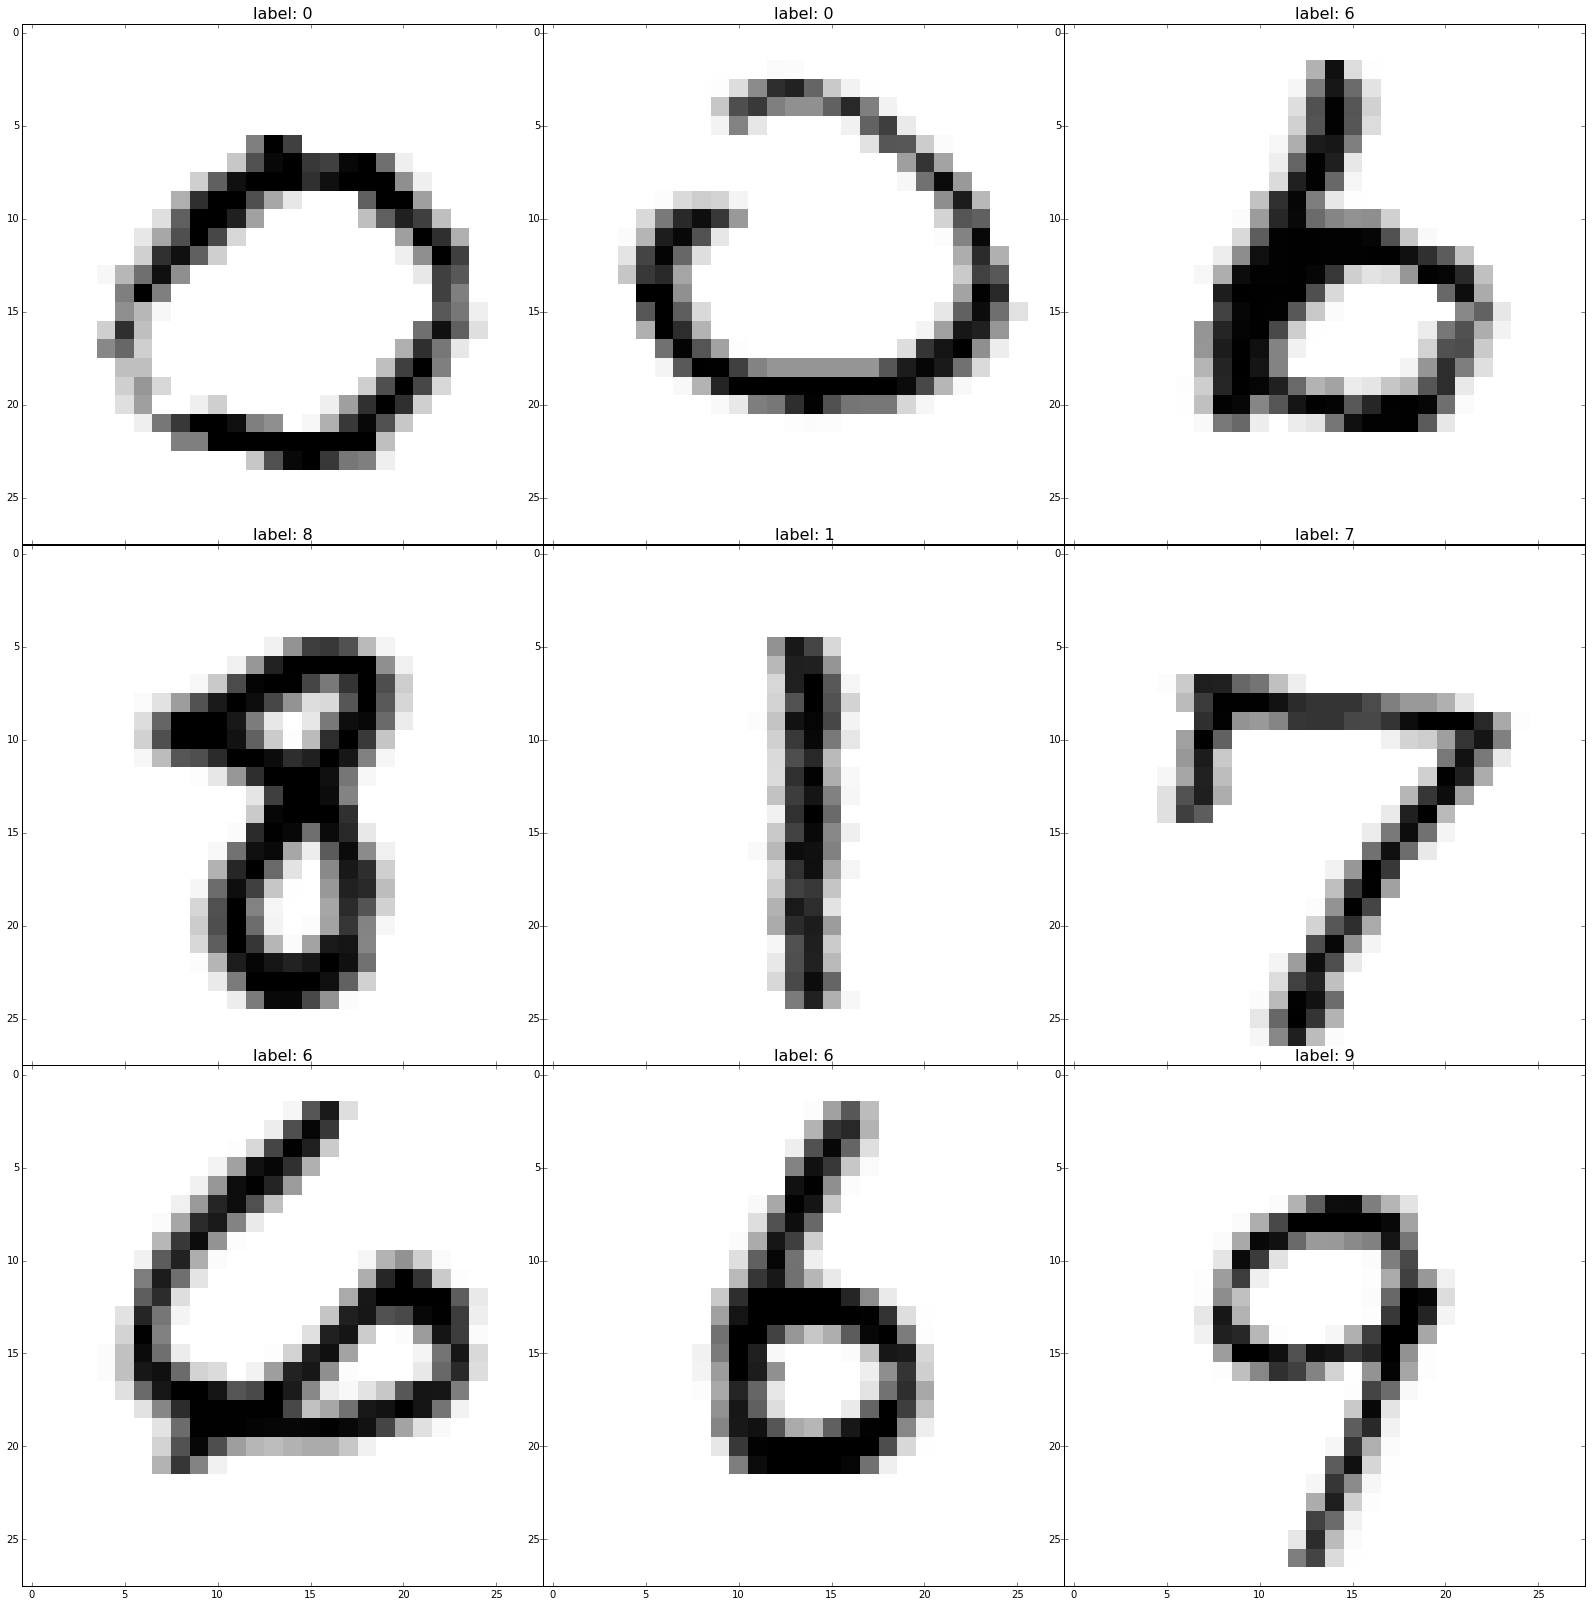

In [35]:
print_imgs(images           = trainX, 
           actual_labels    = trainY.ravel(), 
           predicted_labels = trainY.ravel(),#np.random.permutation(trainY), 
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 3)

***
#Fit the training set with optimal parameters

##Parameter Settings

In [36]:
# default parameters for GradientBoostingClassifier
# =================================================
default_gbm_params = {}
default_gbm_params['loss'] = 'deviance'

default_gbm_params['learning_rate'] = 0.01 
default_gbm_params['n_estimators']  = 1650

default_gbm_params['max_depth']      = 4     # fix the tree size
default_gbm_params['max_leaf_nodes'] = None  # choose tree size by deviance reduction
                                             # Note: these two are mutually exclusive

default_gbm_params['subsample']    = 0.5     # stochastic by observations
default_gbm_params['max_features'] = None    # stochastic by columns (similar to random forest)

default_gbm_params['min_samples_split'] = 2 
default_gbm_params['min_samples_leaf']  = 1 
#default_gbm_params['min_weight_fraction_leaf'] = 0.0

default_gbm_params['init']         = None 
default_gbm_params['random_state'] = 1009    # set a random seed
default_gbm_params['verbose']      = 0 
default_gbm_params['warm_start']   = False

# set parameters for the estimator
gbm_params = dict(default_gbm_params)

# the classifier
gbm_clf = GradientBoostingClassifier(**gbm_params)

##Fit the classifier to the training set

In [37]:
t0 = time.time()

gbm_clf.fit(trainX, trainY)

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in minutes 916.97


#Predict the test set

In [38]:
t0 = time.time()

predicted_values = gbm_clf.predict(testX)

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in minutes 0.11


##Analyze the result

In [39]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

y_true, y_pred   = testY.ravel(), predicted_values

print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.97      0.97      1032
          3       0.96      0.98      0.97      1010
          4       0.97      0.97      0.97       982
          5       0.98      0.97      0.97       892
          6       0.98      0.97      0.98       958
          7       0.97      0.97      0.97      1028
          8       0.96      0.97      0.97       974
          9       0.97      0.95      0.96      1009

avg / total       0.97      0.97      0.97     10000



[[ 974    0    0    1    0    0    1    1    3    0]
 [   0 1125    2    3    0    1    3    0    1    0]
 [   4    0  996    7    2    0    1    6   16    0]
 [   0    0    5  988    0    7    0    5    2    3]
 [   1    0    3    0  957    0    7    0    3   11]
 [   2    0    0   14    2  862    5    1    5    1]
 [   7    3    0    1    5    6  932    0    4    0]
 [   2    3    9    1    4    0    0  999    1    9]
 [   3    0    3    4    3    2    3    1  949    6]
 [   7    4    2    6   14    1    0   12    5  958]]

Model accuracy: 0.974, model misclass rate: 0.026


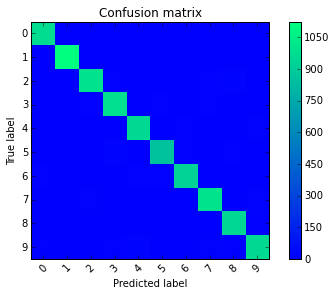

In [40]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Confusion matrix', 
                          cmap=plt.cm.winter):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)